<a href="https://colab.research.google.com/github/Keshavans/home/blob/master/Monte_carlo_CVAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Impléméentation des méthodes naives et améliorées

## 1) Méthode naive

In [ ]:
from typing import Callable, List, Tuple
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt


def compute_var_cvar(alpha: float, n:int = 0) -> Tuple[Tuple[float, float], List[Tuple[float, float]]]:

    C0 = 0
    xi0 = 0
    gamma1 = 1

    d = 4 # Dimension du portefeuille

    poids = np.array([1]*d)

    def phi(X: np.ndarray, poids: np.ndarray = poids) -> float:
        """
        Calcule la perte du portefeuille en fonction des nouveaux prix des actifs.

        :param X: Un vecteur numpy de dimension d représentant les prix des actifs.
        :param poids: Un vecteur numpy de dimension d représentant les poids des actifs dans le portefeuille.
        :return: La perte totale du portefeuille comme un scalaire.
        """
        perte = np.dot(X, poids)
        return perte

    def H1(alpha: float, xi:float, x: List[float]) -> float:
        return 1 - (1/(1-alpha)) * int(phi(x) >= xi)

    def H2(alpha: float, xi: float, c: float, x: List[float]) -> float:
        return c - xi - (1/(1 - alpha)) * max(phi(x) - xi, 0)

    def gamma(n: int) -> float:
        return gamma1/n


    def X(d: int = d) -> np.ndarray:
        return np.random.normal(0, 1, d)

    def has_converged(arr: List[Tuple[float, float]], epsilon: float = 1e-4) -> bool:
        if len(arr) < 5:
            return False
        else:
            # Extraire les 4 derniers tuples et calculer leur moyenne
            last_four = arr[-4:]
            mean_last_four = tuple(np.mean(last_four, axis=0))
            # Calculer la distance euclidienne entre la moyenne et le dernier tuple
            distance = np.linalg.norm(np.array(mean_last_four) - np.array(arr[-1]))
            return distance < epsilon

    rec_var_cvar = [(xi0, C0)]
    max_iterations = n
    iterations = 1

    while (n > 0 and iterations < max_iterations) or (n == 0 and not has_converged(rec_var_cvar)):
        xin_1 = rec_var_cvar[-1][0]
        Cn_1 = rec_var_cvar[-1][1]
        rec_var_cvar.append((xin_1 - gamma(iterations)*H1(alpha, xin_1, X()), Cn_1 - gamma(iterations)*H2(alpha, xin_1, Cn_1, X())))
        iterations += 1

    return rec_var_cvar[-1], rec_var_cvar




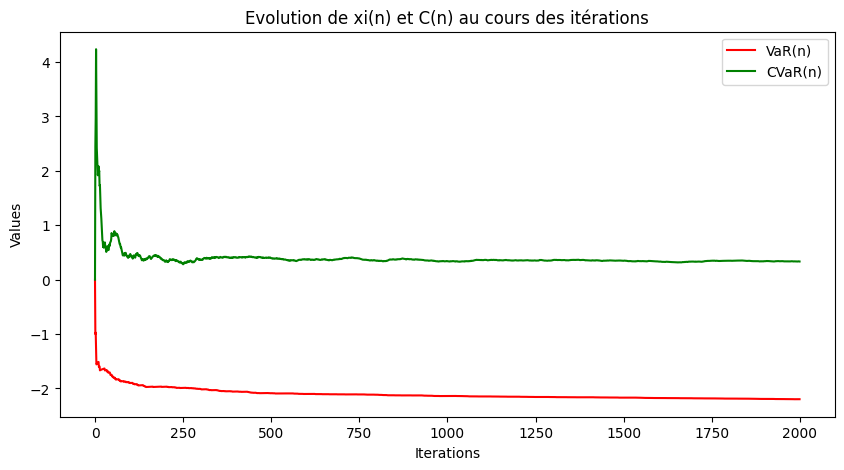

In [ ]:
(var, cvar), history = compute_var_cvar(0.05, 2000)

x_vals, y_vals = zip(*history)

plt.figure(figsize=(10, 5))

# Temps comme abscisse pour les deux séries de données
time = range(len(x_vals))

# Tracer les deux dimensions comme deux lignes différentes
plt.plot(time, x_vals, label='VaR(n)', color='r')
plt.plot(time, y_vals, label='CVaR(n)', color='g')

# Ajouter des titres et des étiquettes
plt.title('Evolution de xi(n) et C(n) au cours des itérations')
plt.xlabel('Iterations')
plt.ylabel('Values')
plt.legend()

# Afficher le graphique
plt.show()

On voit qu'au bout de 400/500 itérations, les valeurs sont stabilisées, on note cela pour l'estimation par la LGN/TCL juste après.

Done 99.95%


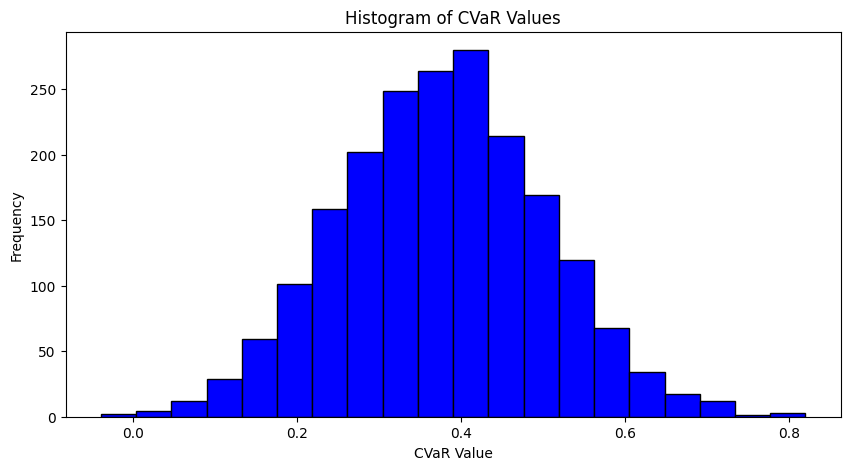

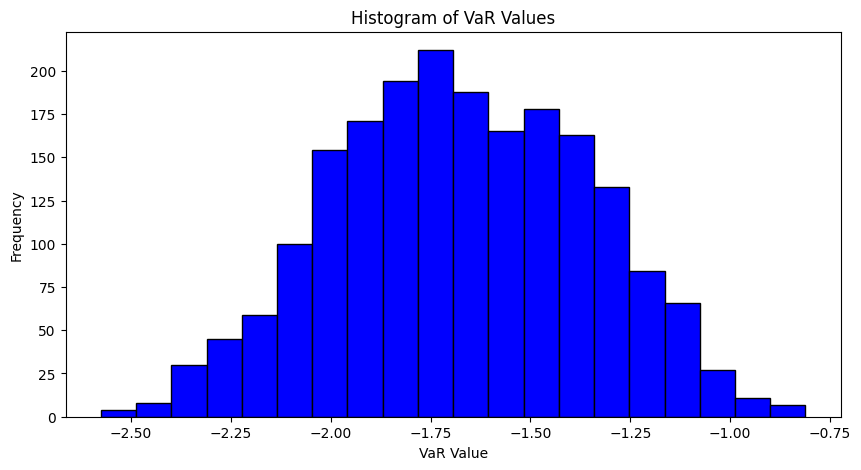

In [ ]:
from math import sqrt
from IPython.display import clear_output, display


varss = []
cvars = []

def var_cvar_bar(history):
    return sum([t[0] for t in history]), sum([t[1] for t in history])

n_max = 500
n_rounds = 2000
alpha = 0.05


for i in range(1, n_rounds):
    clear_output(wait=True)
    print(f"Done {100*(i/n_rounds):.2f}%")
    (var, cvar), history = compute_var_cvar(alpha, n_max)
    var_bar, cvar_bar = var_cvar_bar(history)
    varss.append((1/n_max)*var_bar)
    cvars.append((1/n_max)*cvar_bar)

# Créer l'histogramme des valeurs CVaR
plt.figure(figsize=(10, 5))
plt.hist(cvars, bins=20, color='blue', edgecolor='black')

# Ajouter des titres et des étiquettes
plt.title('Histogram of CVaR Values')
plt.xlabel('CVaR Value')
plt.ylabel('Frequency')

# Afficher l'histogramme
plt.show()

# Créer l'histogramme des valeurs VaR
plt.figure(figsize=(10, 5))
plt.hist(varss, bins=20, color='blue', edgecolor='black')

# Ajouter des titres et des étiquettes
plt.title('Histogram of VaR Values')
plt.xlabel('VaR Value')
plt.ylabel('Frequency')

# Afficher l'histogramme
plt.show()

On voit 2 gaussiennes comme ce qui est montré page 198

In [ ]:
xi_hat = np.mean(cvars)
C_hat = np.mean(varss)

# Calcul de l'écart-type de l'estimateur
cvar_sigma_hat = np.sqrt(np.std(cvars) / n_max)
var_sigma_hat = np.sqrt(np.std(varss) / n_max)

# Détermination de la valeur critique z_alpha/2
conf_alpha = 0.01
z = norm.ppf(1 - conf_alpha / 2)

print("Les valeurs trouvées sont :")
print(f"VaR = {C_hat:.3f} +- {z * var_sigma_hat:.3f} à {100 * (1 - conf_alpha):.0f}%")
print(f"CVaR = {xi_hat:.3f} +- {z * cvar_sigma_hat:.3f} à {100 * (1 - conf_alpha):.0f}%")

Les valeurs trouvées sont :
VaR = -1.673 +- 0.065 à 99%
CVaR = 0.377 +- 0.041 à 99%
